# Objectives
Here, our objective is to predict how much electric will be produced in India in a certain period by using `prophet`. In these days, more and more time series data is being generated and we are required to get insights from these data. From Marketing, IoT, Health to Finance, Information security, time series data appears almost every situation. In TSA, `prophet` is very useful for everyone. So, here I share my knowledge of how to use `prophet` functions in real data analysis, not for manning dataset which is the example in the official documentation.

# About `prophet`
prophet References: https://facebook.github.io/prophet/docs/quick_start.html <br>
Github: https://github.com/facebook/prophet <br>

# Dataset
Electric production in India. The unit is %. 

https://www.kaggle.com/kandij/electric-production

# Libraries

In [4]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

# pystan & prophet

import pystan
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

# Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Check the data

## `.read_csv()`

- `DATE`、lagged values `Value`
- When we use `prophet`, the date column should be `ds`, the value column should be `y`.<br>
- To change the columns names, take the arguments of `names=["ds", "y"],header=0` in `read_csv()`. 
- Don't set the date column as an index. 
- `parse_dates` make the column `datetime` type.

In [6]:
df = pd.read_csv('./gdrive/My Drive/sandbox/Electric_Production.csv', names=["ds", "y"], header=0, parse_dates = ['ds'])

# df = pd.read_csv("Electric_Production.csv", names=["ds", "y"],header=0, parse_dates = ['ds'])

## `.head()` `.tail()`

In [7]:
display(df.head(3))
display(df.tail(3))

,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502


,ds,y
394,2017-11-01,97.3359
395,2017-12-01,114.7212
396,2018-01-01,129.4048


Data range is 1985～2018.
The unit of data is monthly.

## Visualization

At first, see the data.

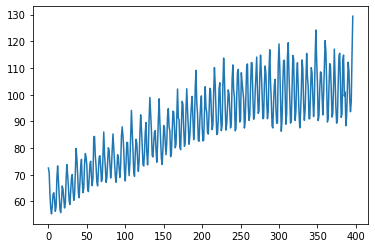

In [8]:
# plot
df["y"].plot()

There are about 400 months data.

- Trend is increasing.
- In small periods, there are intervals.

# Prophet

Basically, 
- Initialize by `Prophet()`
- Define the data by `model.fit()`
- Create the future dataframe by `model.make_future_dataframe()`
- Predict by `model.predict()`

- Yearly seasonality: yearly_seasonality = True or False
- Weekly seasonality: weekly_seasonality = True or False
- Daily seasonality: daily_seasonality = True or False

## Init model

In [9]:
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False)

## Define the data we use

In [10]:
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


## Give the term we want to predict

In [11]:
# monthly data takes periods=12, freq='M' here.
future = model.make_future_dataframe(periods=12, freq='M')
future

,ds
0,1985-01-01
1,1985-02-01
2,1985-03-01
3,1985-04-01
4,1985-05-01
...,...
404,2018-08-31
405,2018-09-30
406,2018-10-31
407,2018-11-30


There are no observed data in this new dataframe.

## Predict

In [12]:
forecast = model.predict(future)

## Check the results

Here, 
- Output the results
- See the effects of each decomposed component on the results

### Output the results

In [13]:
print(forecast.columns)
forecast.tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
404,2018-08-31,104.050673,98.741768,105.751229,104.036409,104.062945,-1.997419,-1.997419,-1.997419,-1.997419,-1.997419,-1.997419,0.0,0.0,0.0,102.053254
405,2018-09-30,104.074156,91.171706,98.686195,104.055058,104.091491,-9.063173,-9.063173,-9.063173,-9.063173,-9.063173,-9.063173,0.0,0.0,0.0,95.010983
406,2018-10-31,104.098421,93.516423,100.992666,104.074083,104.119936,-6.899921,-6.899921,-6.899921,-6.899921,-6.899921,-6.899921,0.0,0.0,0.0,97.198501
407,2018-11-30,104.121904,102.426418,109.782167,104.088534,104.148946,1.994731,1.994731,1.994731,1.994731,1.994731,1.994731,0.0,0.0,0.0,106.116635
408,2018-12-31,104.146170,114.377831,121.936479,104.107237,104.180704,13.912880,13.912880,13.912880,13.912880,13.912880,13.912880,0.0,0.0,0.0,118.059049



- yhat：predicted values
- trend：long-term trend
- yearly：yearly seasonality

upper and lower mean the 80% coverage.

### Visualize the results

`model.plot()`
- Black points: observed values, Blue time series: predicted values, Blue belt:  80% credential interval
- 
- As the prediction periods, there are no observed values
- See the components too.

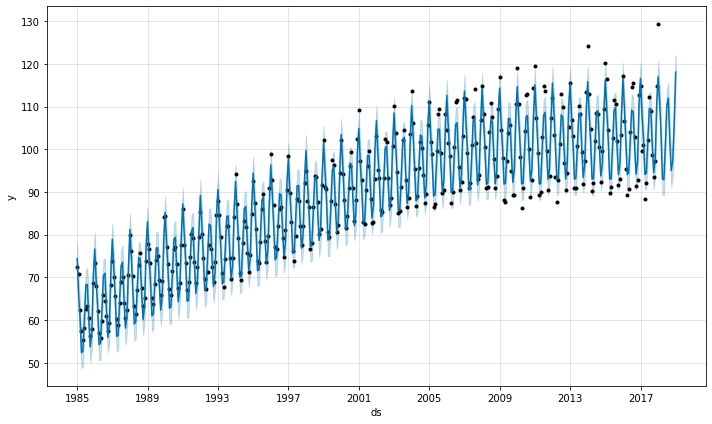

In [14]:
fig1 = model.plot(forecast)

In these days, the observed values deviate from the predicted values.

### See the components effects

`model.plot_components()`

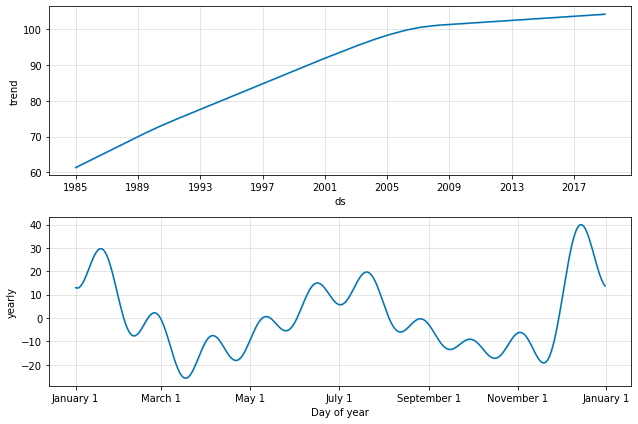

In [15]:
fig2 = model.plot_components(forecast)

- trend: rapidly increasing until 2006 and not so growing after this point 
- yearly: Increase 6-8 and 12-2

## More settings

### trend change points

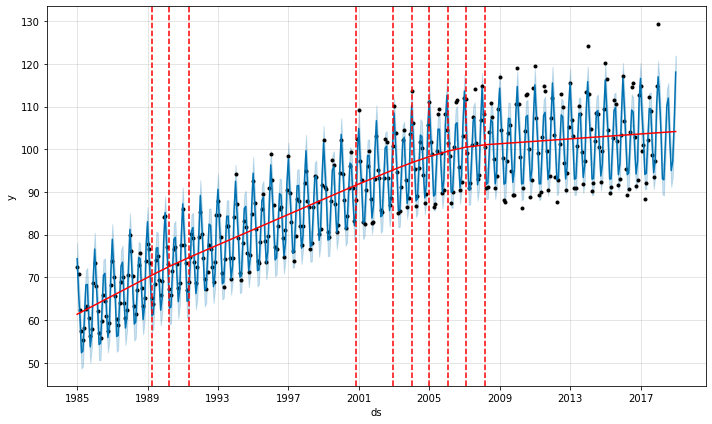

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

There are ten turining points and at these points, the trend changes.

In [17]:
# Include the trend change points in the model
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10)
forecast = model.fit(df).predict(future)

### Holiday effects

We can access the national holidays in the world. <br>
`model.add_country_holidays(country_name='CountryName')` <br>


In [18]:
# include India's national holidays in the model
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10)
model.add_country_holidays(country_name='IN')
forecast = model.fit(df).predict(future)

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



In [ ]:
fig2 = model.plot_components(forecast)

### Additional regressors

Other info can be included in the model as additional regressors. These variable can be continuous and binary.
But, these variables should be added to the future dataframe. This means these values should be observable prior to the dependent variable.

#### Create own regressors

Monthly average temperatures in India

Data：https://data.gov.in/catalog/all-india-seasonal-and-annual-mean-temperature-series?filters%5Bfield_catalog_reference%5D=349261&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc

##### Check the data

In [20]:
IndiaTemp = pd.read_excel('./gdrive/My Drive/sandbox/datafile.xls')
IndiaTemp

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,JAN-FEB,MAR-MAY,JUN-SEP,OCT-DEC
0,1901,17.99,19.43,23.49,26.41,28.28,28.60,27.49,26.98,26.26,25.08,21.73,18.95,24.23,18.71,26.06,27.30,21.92
1,1902,19.00,20.39,24.10,26.54,28.68,28.44,27.29,27.05,25.95,24.37,21.33,18.78,24.33,19.70,26.44,27.18,21.49
2,1903,18.32,19.79,22.46,26.03,27.93,28.41,28.04,26.63,26.34,24.57,20.96,18.29,23.80,19.05,25.47,27.17,21.27
3,1904,17.77,19.39,22.95,26.73,27.83,27.85,26.84,26.73,25.84,24.36,21.07,18.84,23.86,18.66,25.84,26.83,21.42
4,1905,17.40,17.79,21.78,24.84,28.32,28.69,27.67,27.47,26.29,26.16,22.07,18.71,23.71,17.58,24.99,27.37,21.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2013,18.88,21.07,24.53,26.97,29.06,28.24,27.50,27.22,26.87,25.63,22.18,19.69,24.82,19.98,26.85,27.46,22.50
113,2014,18.81,20.35,23.34,26.91,28.45,29.42,28.07,27.42,26.61,25.38,22.53,19.50,24.73,19.58,26.24,27.88,22.47
114,2015,19.02,21.23,23.52,26.52,28.82,28.15,28.03,27.64,27.04,25.82,22.95,20.21,24.91,20.12,26.29,27.73,22.99
115,2016,20.92,23.58,26.61,29.56,30.41,29.70,28.18,28.17,27.72,26.81,23.90,21.89,26.45,22.25,28.86,28.44,24.20


- Need to change the data shape to make its columns `date` and `temp`
- Need only monthly data
- Need to remove the too old data
- Need to impute the data for 2018 because this dataset does not have it.

##### Preprocessing

In [21]:
# Delete columns we do not need
IndiaTemp = IndiaTemp.drop(["ANNUAL", "JAN-FEB", "MAR-MAY", "JUN-SEP", "OCT-DEC"], axis=1)

# Wide to long by melt method
IndiaTemp = IndiaTemp.melt(id_vars='YEAR', var_name='Month').sort_values('YEAR').reset_index(drop=True)
print(IndiaTemp)

# Change the column names
IndiaTemp = IndiaTemp.replace({"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8,
                               "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12})

# year and month to `Date`
IndiaTemp["YEAR"] = pd.to_datetime(IndiaTemp[['YEAR', 'Month']].assign(Day=1))
IndiaTemp = IndiaTemp.rename({"YEAR": "Date"}, axis=1)
IndiaTemp = IndiaTemp.drop(["Month"], axis=1)

# Sort values
IndiaTemp = IndiaTemp.sort_values("Date")

# Choose the years we need in our analysis
IndiaTemp = IndiaTemp.set_index("Date")["1985-01-01": "2017-12-01"]

      YEAR Month  value
0     1901   JAN  17.99
1     1901   FEB  19.43
2     1901   AUG  26.98
3     1901   DEC  18.95
4     1901   JUL  27.49
...    ...   ...    ...
1399  2017   MAR  25.58
1400  2017   FEB  23.08
1401  2017   JAN  20.59
1402  2017   NOV  23.92
1403  2017   DEC  21.47

[1404 rows x 3 columns]


##### Filling missing values

https://qz.com/india/1526467/2018-was-indias-sixth-warmest-year-since-1901-imd-says/
- the temp in 2018 is quite close to that of 2015.

So, let's impute the values of 2015 into 2018.

In [22]:
# Impute the values of 2015 into that of 2015
IndiaTemp_2018 = pd.DataFrame({ 'Date': future.set_index("ds")["2018-01-01": "2018-12-31"].reset_index()["ds"],
                                'value': IndiaTemp["2015-01-01": "2016-01-01"].reset_index().drop("Date", axis=1)["value"]    
                                         })
IndiaTemp_merged = pd.concat([IndiaTemp.reset_index(), IndiaTemp_2018])

# Add the variable to the future dataframe
df["temperature"]=IndiaTemp_merged["value"].reset_index(drop=True)
future["temperature"] = IndiaTemp_merged["value"].reset_index(drop=True)

#### `model.add_regressor('VariableName')`



In [24]:
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10)
model.add_country_holidays(country_name='IN')
model.add_regressor('temperature')

forecast = model.fit(df).predict(future)

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



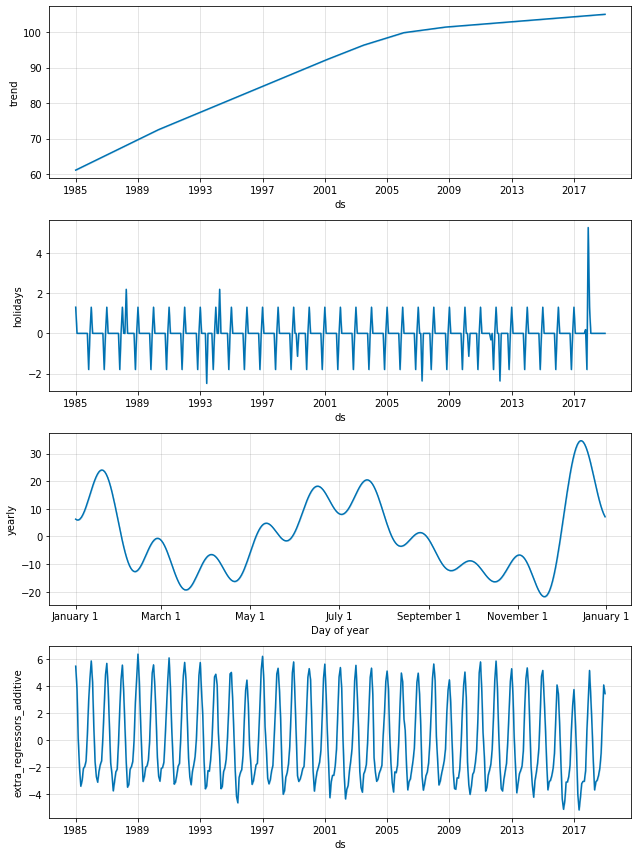

In [25]:
fig2 = model.plot_components(forecast)

Temp does not look related with the DV.

### Additive vs Multiplicative models

構造時系列モデルの組み方として大きく2種類あります。
- 加法モデル
- 乗法モデル

です。<br>

トレンドに応じて変動の大きさが変化する場合には乗法モデルの方があてはまりがよいことがある。<br>
加法モデルはデフォルトで、乗法モデルに変えたいときには、`Prophet()`の引数を`seasonality_mode = 'multiplicative'`とする。

`seasonality_mode = 'multiplicative'`

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



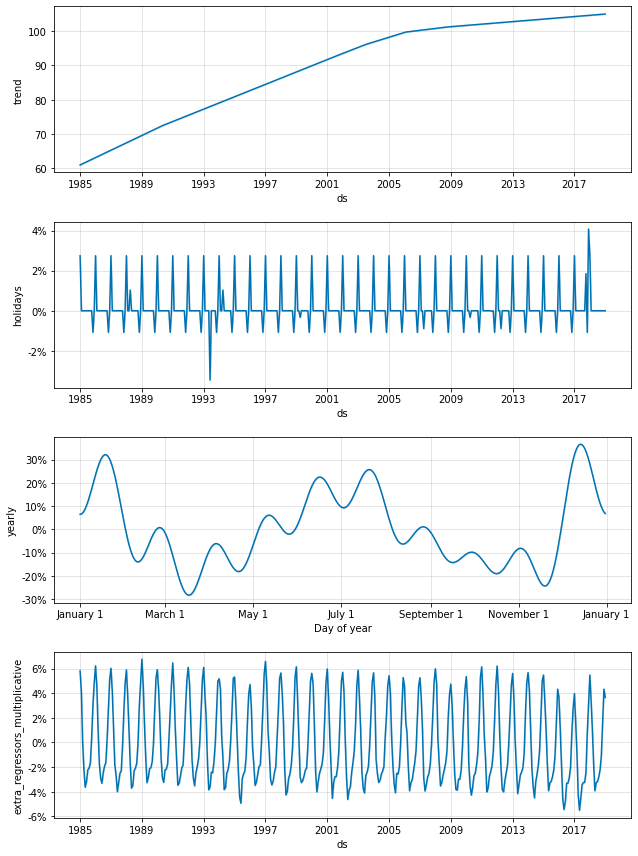

In [26]:
# Multiplicative model
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10,
                seasonality_mode='multiplicative')
model.add_country_holidays(country_name='IN')
model.add_regressor('temperature')

forecast = model.fit(df).predict(future)
fig = model.plot_components(forecast)

## Accuracy

### Cross validation
Arguments are `model`、`initial`、`period`、`horizon`

`model`: Set the model

`initial`: Starting point of validation data

`horizon`: The number of validation data

`period`: The frequency of CV

### The process of CV

here, take the example case.
`cross_validation(model, initial='10950 days', period='180 days', horizon = '90 days')`<br>
When dealing with monthly data, take 1 month =`30 days`.

### Accuracy measures of CV

### Comparison between base model and the model with options

#### Base model

In [27]:
# Prophet()

model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False)

# モデル.fit()
model.fit(df)

In [28]:
# CV
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='10950 days', period='180 days', horizon = '90 days')
df_cv.head(10)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-04-17 00:00:00 and 2017-10-03 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-01,93.954267,90.624508,97.483024,91.0930,2015-04-17
1,2015-06-01,101.648439,98.034911,105.155667,102.6495,2015-04-17
2,2015-07-01,109.454198,106.106852,113.119595,111.6354,2015-04-17
3,2015-11-01,97.313486,93.795325,100.595104,93.0628,2015-10-14
4,2015-12-01,108.953015,105.917048,112.476422,103.2203,2015-10-14
5,2016-01-01,117.091042,113.691796,120.275759,117.0837,2015-10-14
6,2016-05-01,94.648726,91.193825,98.050311,90.7369,2016-04-11
7,2016-06-01,101.911742,98.129532,105.595088,104.0375,2016-04-11
8,2016-07-01,108.422554,104.826908,111.981634,114.5397,2016-04-11
9,2016-11-01,97.752048,94.161180,101.355614,92.8900,2016-10-08


In [29]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-01,93.954267,90.624508,97.483024,91.0930,2015-04-17
1,2015-06-01,101.648439,98.034911,105.155667,102.6495,2015-04-17
2,2015-07-01,109.454198,106.106852,113.119595,111.6354,2015-04-17
3,2015-11-01,97.313486,93.795325,100.595104,93.0628,2015-10-14
4,2015-12-01,108.953015,105.917048,112.476422,103.2203,2015-10-14
5,2016-01-01,117.091042,113.691796,120.275759,117.0837,2015-10-14
6,2016-05-01,94.648726,91.193825,98.050311,90.7369,2016-04-11
7,2016-06-01,101.911742,98.129532,105.595088,104.0375,2016-04-11
8,2016-07-01,108.422554,104.826908,111.981634,114.5397,2016-04-11
9,2016-11-01,97.752048,94.161180,101.355614,92.8900,2016-10-08


In [30]:
# Performance measures
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,14 days,8.186846,2.861267,2.861267,0.031410,0.031410,1.0
1,18 days,18.068331,4.250686,4.250686,0.045675,0.045675,0.0
2,20 days,15.302385,3.911826,3.911826,0.043112,0.043112,0.0
3,24 days,23.639509,4.862048,4.862048,0.052342,0.052342,0.0
4,25 days,3.500910,1.871072,1.871072,0.020320,0.020320,1.0
5,29 days,0.205045,0.452819,0.452819,0.004652,0.004652,1.0
6,45 days,1.002122,1.001061,1.001061,0.009752,0.009752,1.0
7,48 days,32.864018,5.732715,5.732715,0.055539,0.055539,0.0
8,51 days,4.518848,2.125758,2.125758,0.020433,0.020433,1.0
9,54 days,4.422178,2.102898,2.102898,0.018648,0.018648,1.0


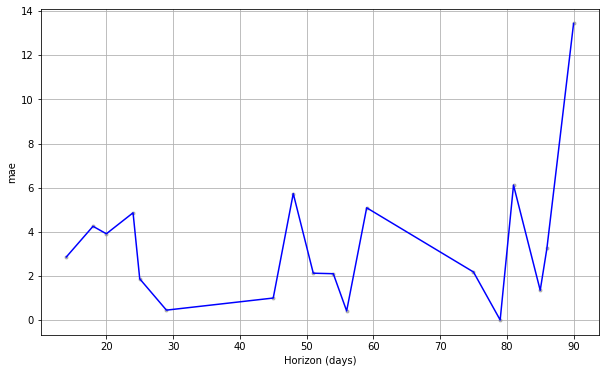

In [31]:
# mapping
# mae
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

#### model with options

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030

/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



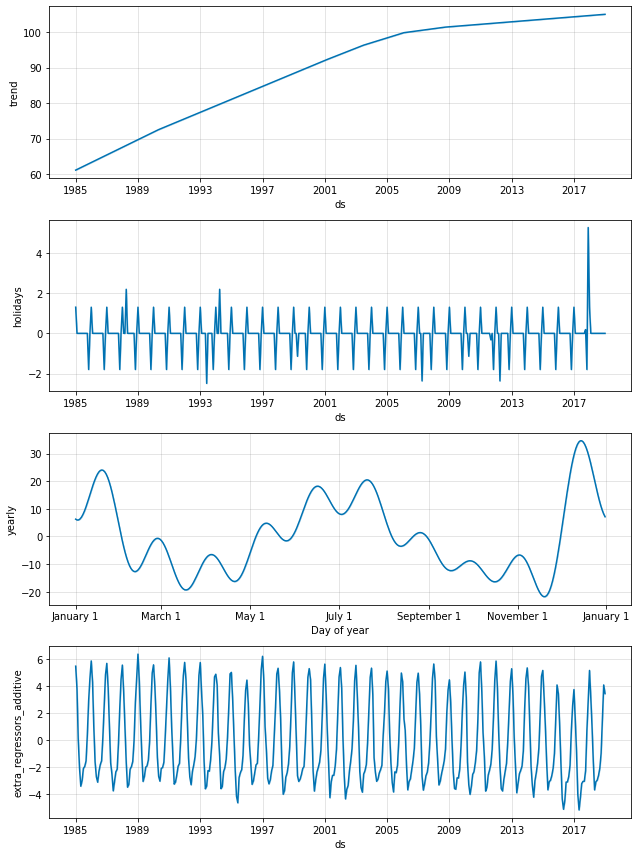

In [32]:
# trend change points, event effects, holidays, additional regressors
model = Prophet(yearly_seasonality = True, 
                weekly_seasonality = False, 
                daily_seasonality = False,
                n_changepoints=10)
model.add_country_holidays(country_name='IN')
model.add_regressor('temperature')

forecast = model.fit(df).predict(future)
fig = model.plot_components(forecast)

In [33]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,All Souls Day,All Souls Day_lower,All Souls Day_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Ashura,Day of Ashura_lower,Day of Ashura_upper,Diwali,Diwali_lower,Diwali_upper,Easter Sunday,Easter Sunday_lower,Easter Sunday_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,"Eid al-Fitr, Gandhi Jayanti","Eid al-Fitr, Gandhi Jayanti_lower","Eid al-Fitr, Gandhi Jayanti_upper",Feast of Holy Family,Feast of Holy Family_lower,Feast of Holy Family_upper,Feast of Pentecost,Feast of Pentecost_lower,Feast of Pentecost_upper,"Feast of Pentecost, Day of Ashura",...,Mawlid,Mawlid_lower,Mawlid_upper,"Mawlid, Gandhi Jayanti","Mawlid, Gandhi Jayanti_lower","Mawlid, Gandhi Jayanti_upper",New Year's Day,New Year's Day_lower,New Year's Day_upper,Palm Sunday,Palm Sunday_lower,Palm Sunday_upper,"Palm Sunday, Day of Ashura","Palm Sunday, Day of Ashura_lower","Palm Sunday, Day of Ashura_upper","Palm Sunday, Feast of the Sacrifice","Palm Sunday, Feast of the Sacrifice_lower","Palm Sunday, Feast of the Sacrifice_upper",Republic Day,Republic Day_lower,Republic Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holidays,holidays_lower,holidays_upper,temperature,temperature_lower,temperature_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1985-01-01,61.095607,70.308010,77.797364,61.095607,61.095607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.299904,1.299904,1.299904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.014556,13.014556,13.014556,5.450675,5.450675,5.450675,1.299904,1.299904,1.299904,5.450675,5.450675,5.450675,6.263976,6.263976,6.263976,0.0,0.0,0.0,74.110162
1,1985-02-01,61.278003,62.459448,69.509643,61.278003,61.278003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.802353,4.802353,4.802353,3.768617,3.768617,3.768617,0.000000,0.000000,0.000000,3.768617,3.768617,3.768617,1.033735,1.033735,1.033735,0.0,0.0,0.0,66.080355
2,1985-03-01,61.442747,56.376132,63.626740,61.442747,61.442747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.415997,-1.415997,-1.415997,0.116663,0.116663,0.116663,0.000000,0.000000,0.000000,0.116663,0.116663,0.116663,-1.532660,-1.532660,-1.532660,0.0,0.0,0.0,60.026750
3,1985-04-01,61.625143,48.302317,55.705971,61.625143,61.625143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.651602,-9.651602,-9.651602,-2.060118,-2.060118,-2.060118,0.000000,0.000000,0.000000,-2.060118,-2.060118,-2.060118,-7.591483,-7.591483,-7.591483,0.0,0.0,0.0,51.973542
4,1985-05-01,61.801656,48.838264,56.304177,61.801656,61.801656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.264688,-9.264688,-9.264688,-3.409363,-3.409363,-3.409363,0.000000,0.000000,0.000000,-3.409363,-3.409363,-3.409363,-5.855325,-5.855325,-5.855325,0.0,0.0,0.0,52.536968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [34]:
# CV
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='10950 days', period='180 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-04-17 00:00:00 and 2017-10-03 00:00:00
/usr/local/lib/python3.6/dist-packages/fbprophet/hdays.py:259: Warning:

We only support Diwali and Holi holidays from 2010 to 2030



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-05-01,93.940496,90.736134,97.609789,91.0930,2015-04-17
1,2015-06-01,101.836513,98.260785,105.377350,102.6495,2015-04-17
2,2015-07-01,109.450301,105.974784,112.661731,111.6354,2015-04-17
3,2015-11-01,97.208876,94.182546,100.566966,93.0628,2015-10-14
4,2015-12-01,108.849114,105.381793,112.430211,103.2203,2015-10-14


In [35]:
# Performance measures
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,14 days,8.108235,2.847496,2.847496,0.031259,0.031259,1.0
1,18 days,17.189949,4.146076,4.146076,0.044551,0.044551,0.0
2,20 days,10.171514,3.189281,3.189281,0.035149,0.035149,1.0
3,24 days,17.018189,4.125311,4.125311,0.044411,0.044411,0.0
4,25 days,1.249168,1.117662,1.117662,0.012138,0.012138,1.0
5,29 days,0.939992,0.969532,0.969532,0.009961,0.009961,1.0
6,45 days,0.660949,0.812987,0.812987,0.007920,0.007920,1.0
7,48 days,31.683542,5.628814,5.628814,0.054532,0.054532,0.0
8,51 days,5.872373,2.423298,2.423298,0.023293,0.023293,1.0
9,54 days,9.642021,3.105160,3.105160,0.027535,0.027535,1.0


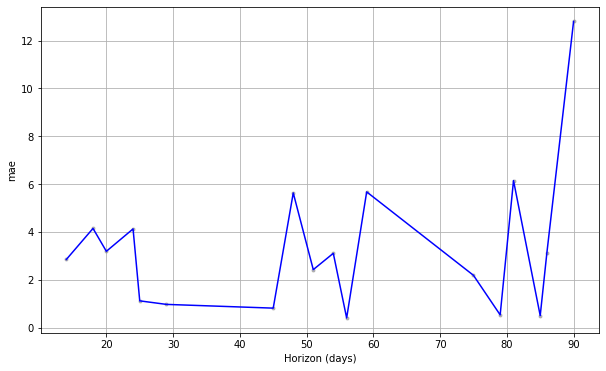

In [36]:
# mapping
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

As we see, adding more options to the model improves the accuracy of prediction!!